In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
#import eli5
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
from skorch.callbacks import Checkpoint, TrainEndCheckpoint
from skorch import NeuralNetRegressor, NeuralNetClassifier
import models
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from colorama import Fore
import pickle as pkl
from tqdm import tqdm
import train

from sklearn import decomposition
import matplotlib.gridspec as grd

Using TensorFlow backend.
/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/linux/anaconda3.7/lib/pytho

In [2]:
df = data_tracks.get_data()
n = df.shape[0]
bases = [f'sc_{i}' for i in range(12)] + [f'nmf_{i}' for i in range(12)]
patches = ['up_max', 'down_max', 'left_max', 'right_max']
feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement', 
              'rise', 'fall', 'X_std', 'X_min', 'X_mean', 'max_diff', 'min_diff'] + bases + patches

/accounts/grad/xsli/abc-image-understanding/data_tracks.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['X_max'] = np.array([max(x) for x in df.X.values])
/accounts/grad/xsli/abc-image-understanding/data_tracks.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['X_min'] = np.array([max(x) for x in df.X.values])
/accounts/grad/xsli/abc-image-understanding/data_tracks.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

# loop over classifiers

In [35]:
outcome_def = 'y_thresh'
out_dir = f'results/outcome={outcome_def}'
os.makedirs(out_dir, exist_ok=True)
for balancing in ['none']:
    for model_type in tqdm(['irf', 'rf', 'gb', 'logistic', 'dt', 'svm', 'mlp2']):
        for num_feats in [4, 9, 11, 23, 35, 39]: #[23]:# [4, 6, 7, 9, 11]:
            feats = feat_names[:num_feats]
            out_name = f'{model_type}_{num_feats}_{balancing}'
            #print(out_name)
            train.train(df, feat_names=feats, model_type=model_type, balancing=balancing, outcome_def=outcome_def,
                        out_name=f'{out_dir}/{out_name}.pkl')





  0%|          | 0/7 [00:00<?, ?it/s]



 14%|█▍        | 1/7 [00:11<01:06, 11.00s/it]



 29%|██▊       | 2/7 [00:31<01:08, 13.77s/it]



 43%|████▎     | 3/7 [00:41<00:51, 12.76s/it]



 57%|█████▋    | 4/7 [00:42<00:27,  9.18s/it]



 71%|███████▏  | 5/7 [00:45<00:14,  7.39s/it]



 86%|████████▌ | 6/7 [01:10<00:12, 12.71s/it]/accounts/grad/xsli/.local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/accounts/grad/xsli/.local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/accounts/grad/xsli/.local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochas

# classifier eda

/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


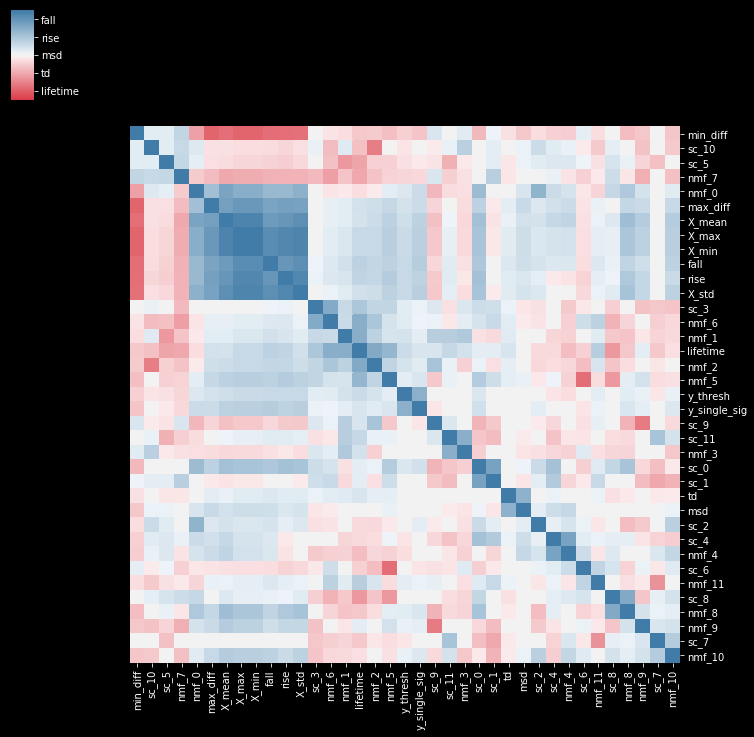

In [10]:
X = df[feat_names + ['y_thresh', 'y_single_sig']]
X = X.rename(columns={'mean_square_displacement': 'msd', 'total_displacement': 'td'})
X = (X - X.mean()) / X.std()

# make fig
# plt.figure(dpi=400, figsize=(12, 12))
sns.clustermap(X.corr(method='spearman'), 
               cmap=sns.diverging_palette(10, 240, as_cmap=True, center='light'), 
               vmin=-1, vmax=1, figsize=(12, 12))
plt.xticks(0.5 + np.arange(len(X.keys())), labels=X.keys())
plt.yticks(0.5 + np.arange(len(X.keys())), labels=X.keys())
plt.savefig('results/heatmap.pdf')
plt.show()

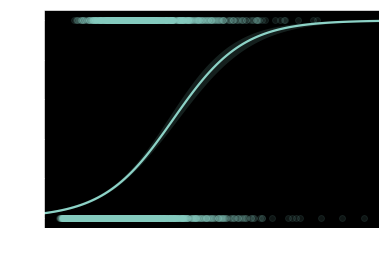

In [2]:
sns.regplot('X_max', 'y_thresh', df, scatter_kws={'alpha': 0.1}, logistic=True)
plt.hist(df['lifetime'][df['y_thresh']==0], alpha=0.5)
plt.hist(df['lifetime'][df['y_thresh']==1], alpha=0.5)
plt.show()

# dim reduction

In [68]:
feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement', 
                          'rise', 'fall', 'X_std', 'X_min', 'X_mean', 'max_diff', 'min_diff']
X = df[feat_names]
X = (X - X.mean()) / X.std()
y = df['y_thresh'].values

**look at pcs**

In [ ]:
def plot_pcs(pca, comps):

    # create a 2 X 2 grid 
    gs = grd.GridSpec(2, 2, height_ratios=[2,10], 
                      width_ratios=[12, 1], wspace=0.1, hspace=0)

    var_norm = pca.explained_variance_ / np.sum(pca.explained_variance_) * 100
    # plot explained variance
    ax2 = plt.subplot(gs[0])
    ax2.bar(np.arange(0, comps.shape[1]), var_norm, 
            color='gray', width=0.8)
    plt.title('Explained variance (%)')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.yaxis.set_ticks_position('left')
    ax2.set_yticks([0, max(var_norm)])
    plt.xlim((-0.5, comps.shape[1]-0.5))
    
    # plot pcs
    ax = plt.subplot(gs[2])
    p = ax.imshow(comps, interpolation='None', cmap=sns.diverging_palette(10, 240, as_cmap=True, center='light'), aspect='auto') #, vmin=-1, vmax=1)
#     plt.ylabel('Feature number')
    plt.xlabel('PCA component number')
    ax.set_yticklabels(list(X))
    ax.set_yticks(range(len(list(X))))
    

    # make colorbar
    colorAx = plt.subplot(gs[3])
    cb = plt.colorbar(p, cax = colorAx)
    plt.show()
    

# perform pca
pca = decomposition.PCA(whiten=True)
# pca = decomposition.SparsePCA()
# pca = decomposition.NMF()
pca.fit(X)
comps = pca.components_.transpose()
plt.figure(figsize=(6, 5), dpi=200)
plot_pcs(pca, comps)

In [ ]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)
plt.figure(dpi=200)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df['y_thresh'].values, alpha=0.1)
plt.xlabel('PC1')
plt.ylabel('PC2')
#             cdf[np.arange(X.shape[0]), cmap='viridis', alpha=0.1)
plt.show()